# Projet Chars74k
Mis au point d'un modèle Deep Learning permettant de faire de la transcription i.e un modèle qui puisse identifier le caractère à l’image.

**Description du Dataset Le dataset Chars74k **

Le dataset Contient des images de caractères de la langue anglaise (alphabet latin) repartie en 62 classes (0-9, A-Z, a-z) comme suit :


*   7705 d'images de caractères issus d’images réelles (EnglishImg)
*    3410 d'images de caractères dessinés sur tablette(EnglishHnd)
*    62992 d'images de caracteres issus de police de caractère(EnglishFnt)

Ceux qui fait au total 74K (d'ou le nom du Dataset chars74K )








# Importons les données de chars74k et commençons à les manipuler. 
Pour ce faire, plutôt que d'importer les données à la main, nous allons utiliser un dossier sur le drive associé au compte google connecté à ce colab. Veillez donc à avoir auparavant chargé un dossier nommé 'chars74k' comprenant les trois sous-ensembles du dataset compressé.

Lions notre drive à ce colab avec la commande suivante :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Maintenant que le drive est monté, nous pouvons y naviguer pour trouver nos données ! Pour cela, colab autorise le lancement de commande unix si l'on utilise un '!' devant la commande, comme suit : 

In [2]:
!ls /content/drive

MyDrive  Othercomputers  Shareddrives


On peut voir un élément nommé 'MyDrive' dans le chemin donné pour monter le drive. Explorons ce chemin et tentons d'y trouver le dossier associé à nos données 

In [3]:
!ls /content/drive/MyDrive/chars74K

EnglishFnt.tgz	EnglishHnd.tgz	EnglishImg.tgz


J'observe bien mes trois dossier compressés !

Empressons nous de décompresser ces dossiers, et de récupérer les chemins associés sous forme de variables manipulables : 



In [4]:
# !tar -xzvf "/content/drive/MyDrive/chars74k.tgz" -C "/tmp/"     #[run this cell to extract tar.gz files]



import tarfile
import os 
path_to_dataset = '/content/drive/MyDrive/chars74K'


for (root,dir,files) in os.walk(path_to_dataset):
  for filename in files:
    print(os.path.join(root,filename))
    tar = tarfile.open(os.path.join(root,filename))
    tar.extractall()
  break


/content/drive/MyDrive/chars74K/EnglishFnt.tgz
/content/drive/MyDrive/chars74K/EnglishHnd.tgz
/content/drive/MyDrive/chars74K/EnglishImg.tgz


Les données ont été extraites à la racine de ce notebook, explorons ce dernier ! 

In [5]:
!ls 

drive  English	sample_data


Il y a maintenant un dossier "English" dans ma racine, que je peux aller regarder avec toujours la même commande : 

In [6]:
!ls ./English

Fnt  Hnd  Img


## **Visusalisation des données**

Les données sont réparties entre trois dossiers : Fnt,Hnd,Img (voir description du projet en haut ). 

*  Dans Fnt on a 62 sous dossiers qui jouent le role de labels pour les differentes classe de caracteres (0-9 A-Z a-z);

*   Dans Hnd on a un dossier Img qui contient a son tour 62 sous dossiers qui jouent le role de labels pour les differentes classe de caracteres. Nous avons aussi dans Hnd un dossier nommé Trj;

*   Dans Img on a un dossier GoodImg qui a son tour contient deux sous dossiers :
-->Bmp qui contient des images de caracteres reparties en 62 sous dossiers pour chaque classe de caractere (0-9 A-Z a-z);
-->Msk qui corresponde au masques de segmentation binaire des images 


On a du utilisé aussi un logiciel pour extraire nos donnée en local (7 Zip) pour mieux voir ce qui se cache dans notre dataset
.



Et voilà mes trois dossiers contenant mes images ! 
Essayons de visualiser ces dernières ... 

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#  
# Regardons des blocs de 4*4 de nos images 
#
def plot_images(directory):
  nrows = 4
  ncols = 4
  pic_index = 0
  count = 0
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  for classe in os.listdir('%s'%directory):

    sample_dir = os.path.join(directory, '%s'%classe)
    if not os.path.isdir(sample_dir):
      continue
    sample_fnames = os.listdir(sample_dir)
    pic_index += 8
    next_sample001_pix = [os.path.join(sample_dir, fname) 
                  for fname in sample_fnames[pic_index-8:pic_index]]
    for i, img_path in enumerate(next_sample001_pix):
      sp = plt.subplot(nrows, ncols, i + 1)
      sp.axis('Off') # Les axes ne seront pas affichés
      img = mpimg.imread(img_path)
      plt.imshow(img)
      count += 1

    plt.show()
  print('Nombre d\'images visualisées :',count)
  print("Taille d'une image aléatoire : {}".format(img.shape))



FNT_directory = '/content/English/Fnt/'
HND_directory = '/content/English/Hnd/Img'
Good_Img_directory = '/content/English/Img/GoodImg/Bmp'
Bad_Img_directory = '/content/English/Img/BadImag/Bmp'



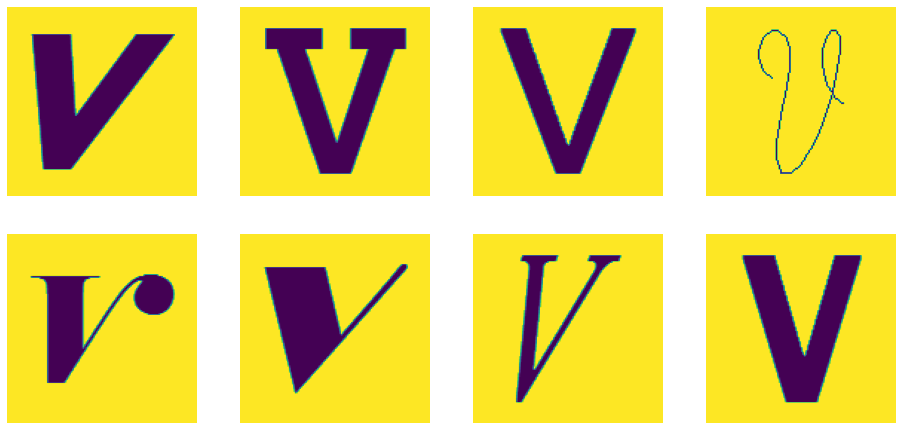

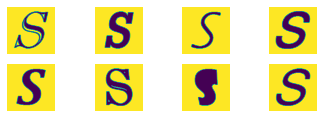

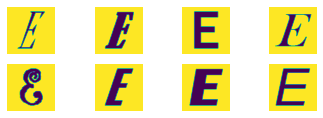

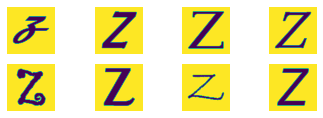

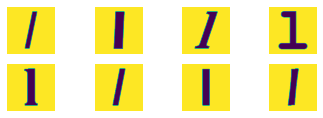

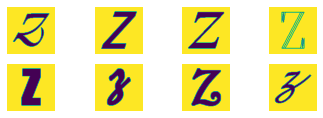

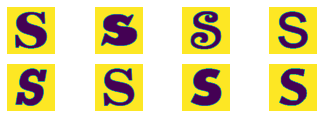

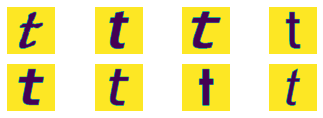

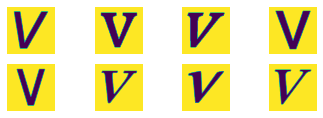

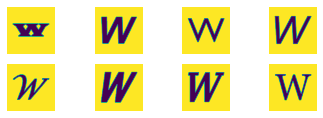

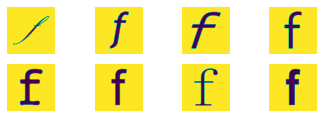

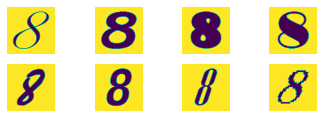

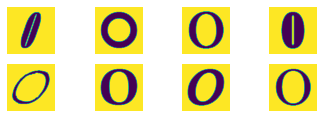

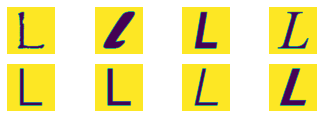

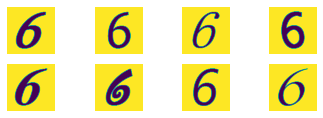

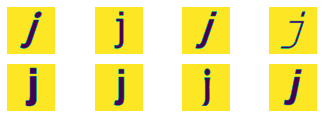

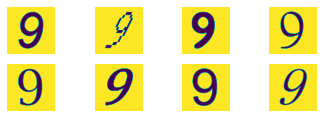

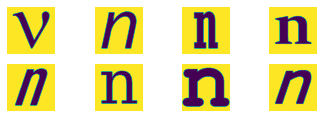

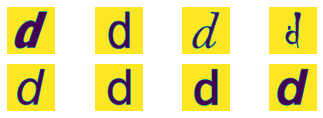

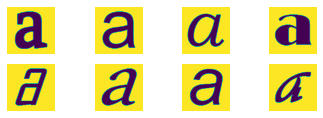

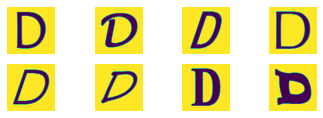

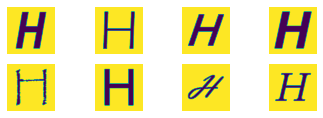

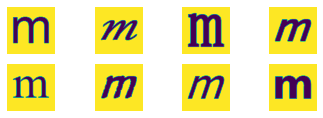

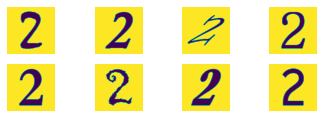

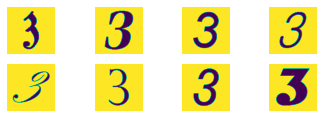

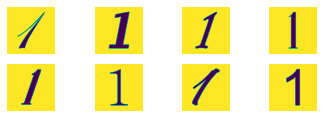

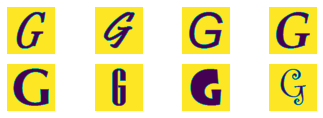

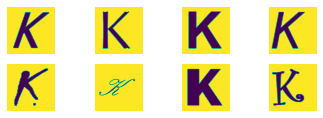

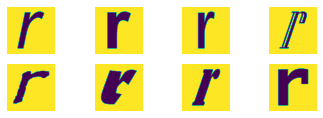

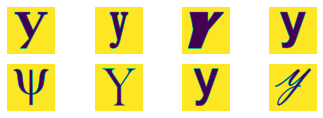

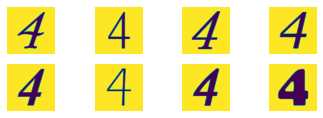

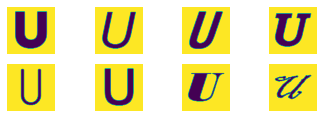

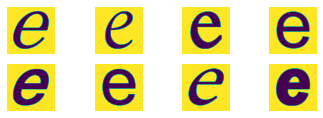

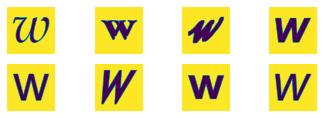

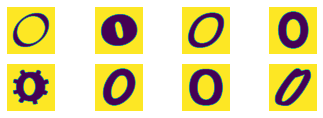

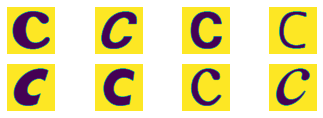

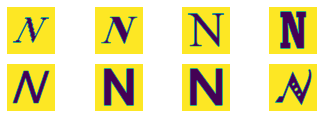

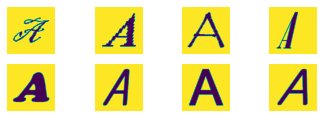

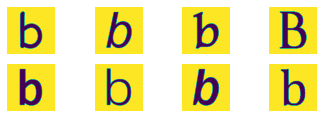

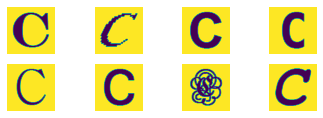

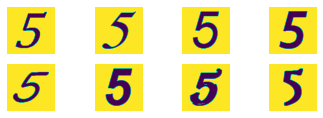

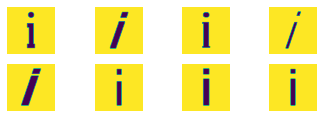

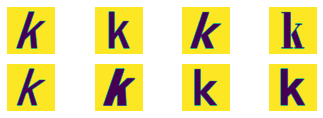

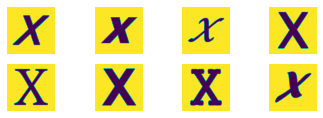

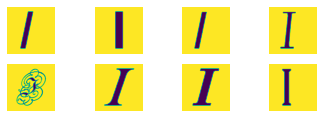

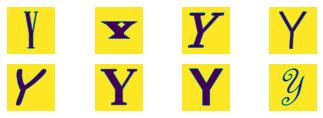

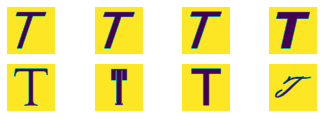

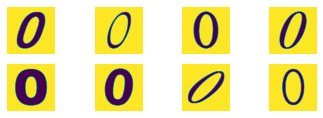

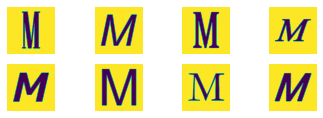

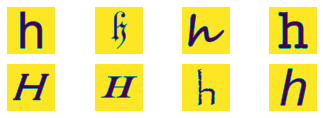

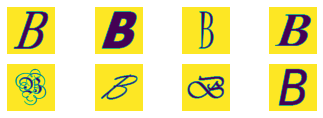

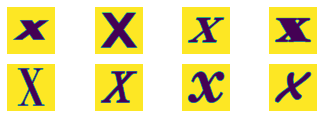

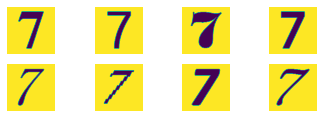

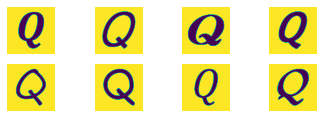

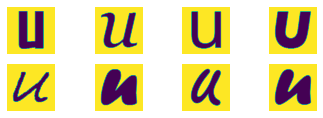

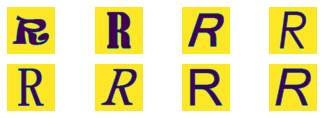

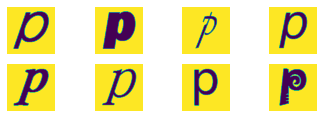

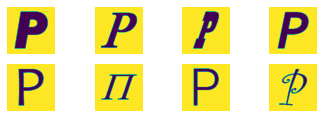

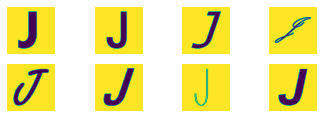

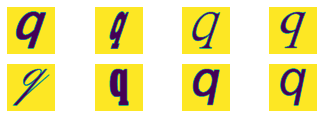

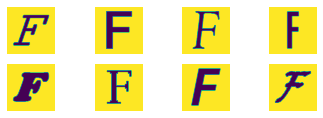

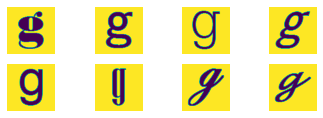

Nombre d'images visualisées : 496
Taille d'une image aléatoire : (128, 128)


In [8]:
# Visualisons quelques caracteres issues de police de caracteres
plot_images(FNT_directory)

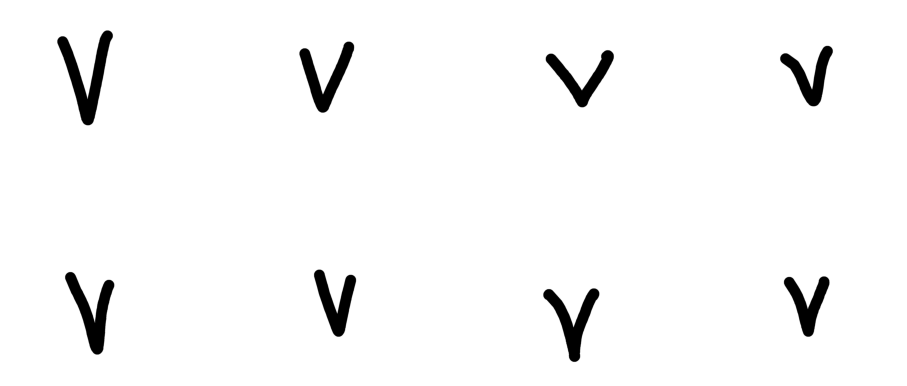

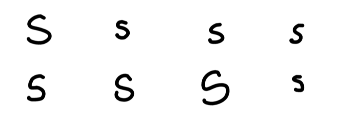

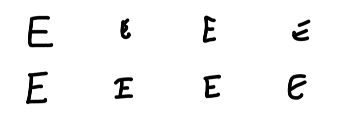

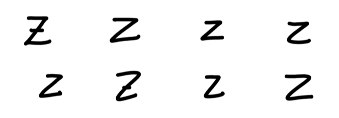

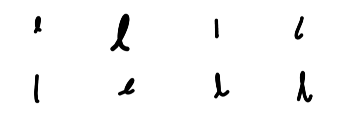

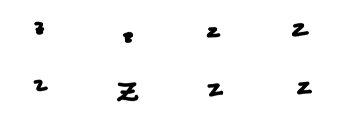

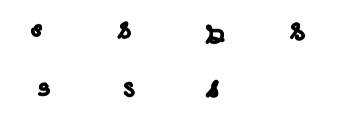

Nombre d'images visualisées : 55
Taille d'une image aléatoire : (900, 1200, 3)


In [9]:
# Visualisons quelques caracteres manuscrites
plot_images(HND_directory)

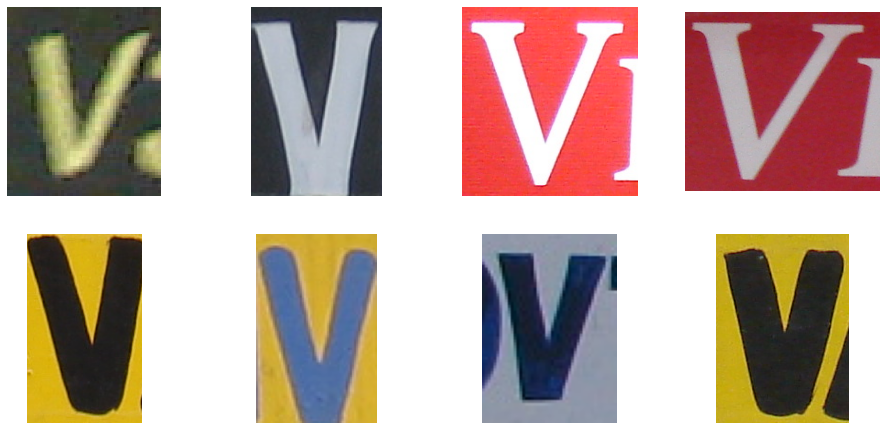

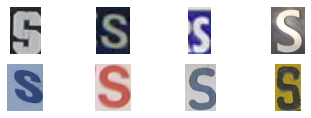

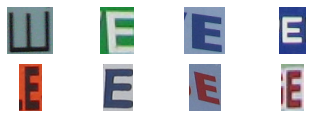

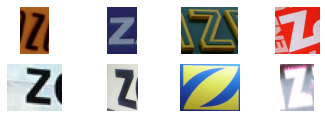

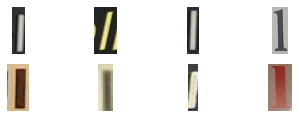

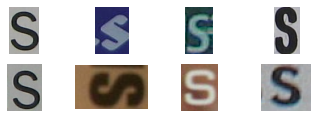

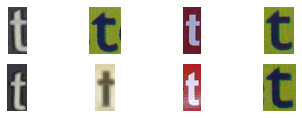

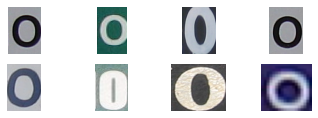

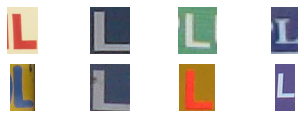

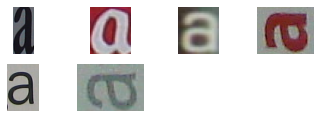

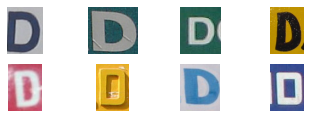

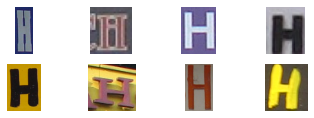

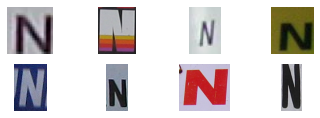

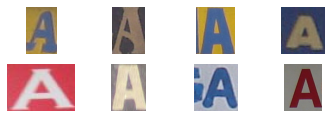

Nombre d'images visualisées : 110
Taille d'une image aléatoire : (139, 109, 3)


In [10]:
plot_images(Good_Img_directory)

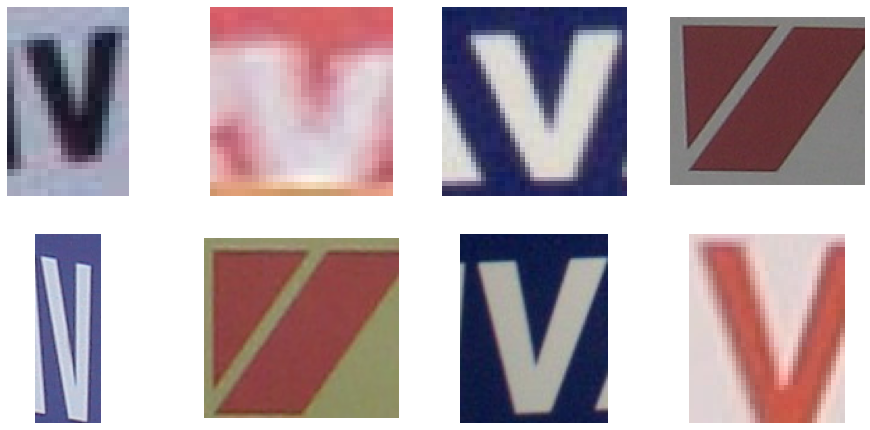

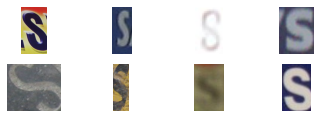

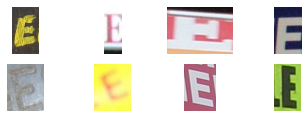

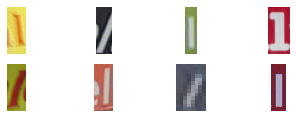

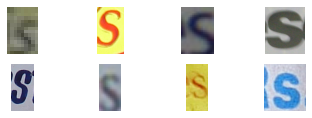

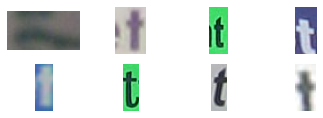

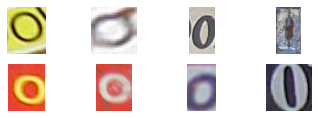

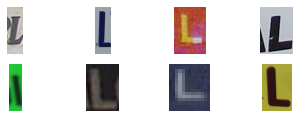

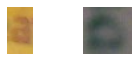

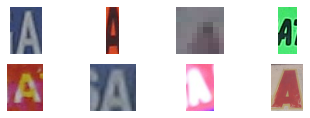

Nombre d'images visualisées : 74
Taille d'une image aléatoire : (278, 185, 3)


In [11]:
plot_images(Bad_Img_directory)

On observe a l'aide des visualisations ci-dessus:


*   des images disparates : de taille et nature différente
*   une variation entre les polices de caractere pour les images issues de police de caractere (Fnt)

*   une variation entre les caracteres manuscrites
*  une variation entre les caracteres  issus d'images reeles avec des caracteres parfois horizontals ou obliques (GoodImg)

*   des images majoritairement flous dans le dossier BadImag







**Exploration et formattage des données**

Passons à l'exploration des données.
Commençons par étudier le format des données, la répartition, et ce que les données peuvent nous dire !

In [12]:
def distribution_directory(directory):
  count = 0
  len_samples = []
  no_duplicate = []
  for classe in os.listdir('%s'%directory):
    
    sample_dir = os.path.join(directory, '%s'%classe) 
    if not os.path.isdir(sample_dir):
      continue
    count += 1
    sample_fnames = os.listdir(sample_dir)
    len_samples.append(len(sample_fnames))
    
  no_duplicate = list(set(len_samples))
  print(no_duplicate)  
  print('Total directories in the subset dataset', count)

In [13]:
distribution_directory(FNT_directory)

[1016]
Total directories in the subset dataset 62


Ci-dessus,on remarque qu'il y'a 62 repertoires de meme taile(1016) pour chaque classe de caracteres dans le dossier FNT(les caracteres issues de polices de caracteres)

In [14]:
distribution_directory(HND_directory)

[55]
Total directories in the subset dataset 62


De meme ,on remarque ci-dessus qu'il y'a 62 repertoires de meme taile(55) pour chaque classe de caracteres dans le dossier HND(les caracteres manuscrites).

In [15]:
distribution_directory(Good_Img_directory)

[389, 135, 143, 148, 149, 158, 159, 32, 33, 34, 35, 36, 37, 38, 41, 43, 46, 47, 558, 302, 50, 48, 52, 54, 55, 312, 58, 446, 191, 64, 193, 63, 67, 70, 77, 79, 80, 84, 342, 215, 92, 227, 105, 363, 111, 115, 126, 124, 382, 127]
Total directories in the subset dataset 62


Ici on a 62 repertoires pour chaque classe de caracteres mais avec une repartition differente en terme de nombre (il s'agit de caracteres issues d'images réelles).

On a déjà vu que les images n'avaient pas une taille constante dans ce dataset. Il faudra donc les ramener tous à une même taille, puisque le modèle ne peut pas se permettre de faire varier sa forme d'entrée. Nous devrons donc passer par une étape de formattage de ces données.
Nous ramènerons aussi les valeurs des pixels entre 0 et 1 au lieu de les conserver entre 0 et 255(normalisation).

In [28]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 25
def image_data_generator(data_dir,
                       data_augment=False,
                       batch_size=BATCH_SIZE,
                       target_size=(100, 100),
                       color_mode='rgb',
                       class_mode='categorical',
                       shuffle=True,
                       validation_split=0.2,#this is the trick
                       subset='training'): # set as training data
  if data_augment:
      datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
  else:
      datagen = ImageDataGenerator(rescale=1./255)

  generator = datagen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode=color_mode,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          validation_split=validation_split,
                                          class_mode=class_mode)
  return generator


In [29]:
Fnt_train_generator = image_data_generator(FNT_directory)

TypeError: ignored

In [27]:
Fnt_val_generator = image_data_generator(FNT_directory,subset='validation')

Found 62992 images belonging to 62 classes.


# **QUESTIONS**
Bonjour.
Je suis desolée du retard pour l'envoie du pre-rendu .J'ai pris beaucoup de temps pour l'exploration des données .
J'ai un probleme pour regrouper les données(Fnt,Hnd,Img) et de le les departager en données d'entrainement, données de validation et données de test(eventuellement).
J'ai l'impression que l'argument "validation_split" ne marche pas avec les generateurs d'images.

J'ai aussi une question sur l'option 'validation_split' dans [model.fit].

Ma question est la suivante,

(1) L'option 'validation split' choisit-elle aléatoirement les échantillons de validation ?
(2) Si elle les choisit au hasard, les mélange-t-elle à chaque époque ?
(3) S'il ne les mélange pas, l'option 'shuffle' peut-elle fonctionner pour randomiser le partage de la validation ?

Je sollicite vos reponses sur ces questions.

Je vous remercie.



J'ai aussi un petit soucis avec les parametres retournés avec la methode "summary" lors des premiers couches (voir images ci-joint)
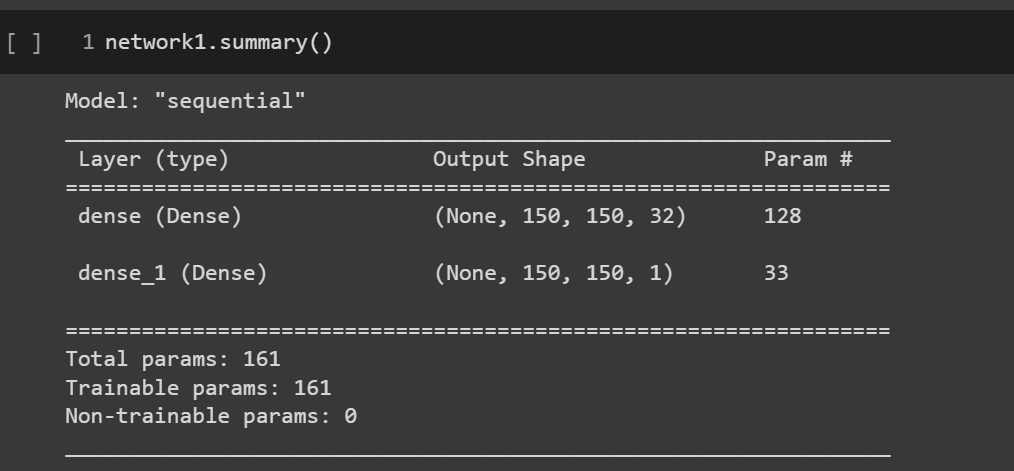

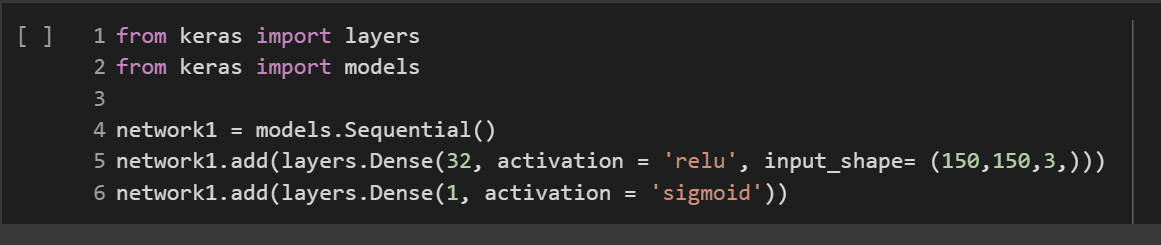